#Code for estimating distance between people:
First mount the drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Import necessary packages

In [3]:
import os
from pathlib import Path
from PIL import Image, ImageDraw
import numpy as np
import pandas as pd
import csv

! pip install supervision
import supervision as sv

import the ultralytics library to import YOLOv8.2.28

In [5]:
! pip install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.2.32 🚀 Python-3.10.12 torch-2.3.0+cu121 CPU (Intel Xeon 2.20GHz)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 30.2/107.7 GB disk)


In [ ]:
from ultralytics import YOLO
import torch

device: str = "cuda" if torch.cuda.is_available() else "cpu"
print(f"device = {device}")

# load the model:
model = YOLO("yolov9c.yaml")
model = YOLO("yolov9c.pt")
model.to(device)

In [ ]:
! pip install numpy
! pip install opencv-python
! pip install tensorflow
! pip install keras

create the CrowdDataset class

1200
train_set length: 768, test_set length: 240, valid_set: 192, sum = 1200


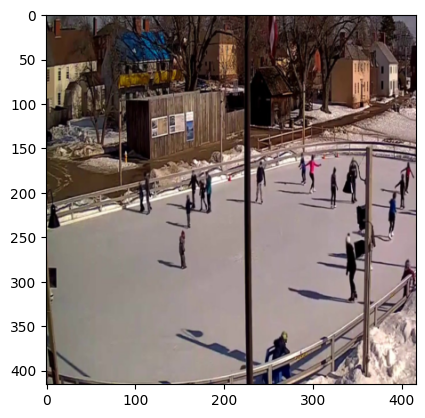

3


In [8]:
import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import os
import cv2
import random
from torch.utils.data import random_split
import matplotlib.pyplot as plt
import numpy as np

class CrowdDataset(Dataset):
  def __init__(self, root_dir, transform = None):
    self.root_dir = root_dir
    self.transform = transform
    self.frames = os.listdir(root_dir)

  def __len__(self):
    return len(self.frames)


  def __getitem__(self, i):
      path_to_ith_img = os.path.join(self.root_dir, self.frames[i])
      img = cv2.imread(path_to_ith_img)
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
      if self.transform:
          img = self.transform(img)
      return img

sample_path = '/content/drive/MyDrive/data/sompt22/test/SOMPT22-03/img1'
transform = transforms.Compose([
    transforms.ToPILImage(),  # Convert NumPy array to PIL Image
    transforms.Resize((416, 416)),
    transforms.ToTensor()# Normalize based on PyTorch ImageNet
])


sample_dataset = CrowdDataset(sample_path, transform)
random.shuffle(sample_dataset.frames)
sample_len = len(sample_dataset.frames)
print(sample_len)


train_set, test_set = random_split(sample_dataset, [int(sample_len * 0.8), sample_len - int(sample_len * 0.8)])
trainset_len = len(train_set)

train_set, valid_set = random_split(train_set, [int(trainset_len * 0.8), trainset_len - int(trainset_len * 0.8)])
print(f'train_set length: {len(train_set)}, test_set length: {len(test_set)}, valid_set: {len(valid_set)}, sum = {len(train_set)+len(test_set)+len(valid_set)}')

train_image_tensor = train_set[0]
train_image = train_image_tensor.numpy()
train_image = train_image.transpose(1, 2, 0)  # Convert from (C, H, W) to (H, W, C)

plt.imshow(train_image)
plt.show()


print(len(train_set[0]))

In [9]:
sample_path ='/content/drive/MyDrive/data/sompt22/test/SOMPT22-03/img1/000001.jpg'
train_image1 = cv2.imread(sample_path)

train_image = cv2.cvtColor(train_image1, cv2.COLOR_BGR2RGB)

transform = transforms.Compose([
    transforms.ToPILImage(),  # Convert NumPy array to PIL Image
    transforms.Resize((416, 416)),
    transforms.ToTensor()# Normalize based on PyTorch ImageNet
])

train_image = transform(train_image).unsqueeze(0)
with torch.no_grad():
  prediction = model.predict(train_image)

image_np = train_image.squeeze(0).permute(1, 2, 0).numpy()


0: 416x416 15 persons, 1676.7ms
Speed: 0.1ms preprocess, 1676.7ms inference, 41.4ms postprocess per image at shape (1, 3, 416, 416)


Draw the bboxes predicted from YOLO:

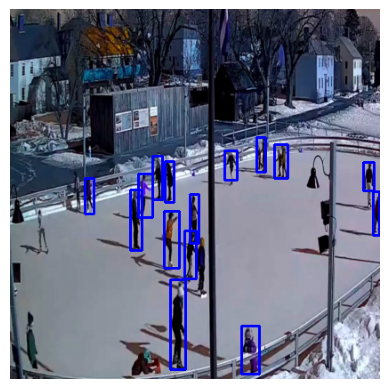

In [12]:
def draw_predicted_bboxes(image, prediction_list):
  for box_coord in prediction_list:
    x_min, y_min, width, height = box_coord[0], box_coord[1], box_coord[2], box_coord[3]
    cv2.rectangle(image, (int(x_min), int(y_min)), (int(x_min + width), int(y_min+height)), (255, 0, 0), 2)
  return image

boxes1 = prediction[0].boxes.xyxy.tolist()
boxes_ref = [[box[0], box[1], box[2] - box[0], box[3] - box[1]] for box in boxes1]

annotated_image = draw_predicted_bboxes(image_np.copy(), boxes_ref)
annotated_image_rgb = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)

# Display the annotated image using Matplotlib
plt.imshow(annotated_image_rgb)
plt.axis('off')
plt.show()

# Get Approximate Crowd Density:

### Steps:
1.   get the four points + use height as scaling factor to convert from pixel to cm (get the average boundary box size and that would be ~ average height of person)
2.   get the subgroup clusters by euclidean distance (in cm)
  - ignore noise (-1)
  - get the area where people are standing (x_max- x_max) * (y_max - y_min) in meters
  - get the number of people in the subgroups
  - divide number of people by area

Marking 4 chosen points (the area that we want to perform perspective transformation on)

<Figure size 640x480 with 0 Axes>

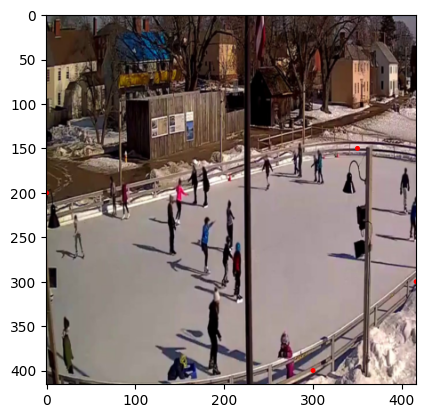

In [28]:
import cv2
# Convert the image to grayscale
gray = cv2.cvtColor(image_np, cv2.COLOR_BGR2GRAY)

def plot_corners(image, corners):
  # Create a plot to draw the image and corners
  corners = np.intp(corners)
  plt.figure()

  fig, ax = plt.subplots()

  # Draw detected corners on the original image
  for corner in corners:
      x, y = corner.ravel()
      circle = plt.Circle((x, y), 2, color='r')
      ax.add_patch(circle)

  # Display the image with detected corners
  ax.imshow(image)
  plt.show()

# Convert the bounding box coordinates to NumPy array for easier manipulation
# top right, bottom right, bottom left, top left
points = [[350, 150],[416,300], [300, 400], [0,200]]
corner_points_arr = np.float32(points[:4])

plot_corners(image_np, points)


Get the average size of the boundary boxes of people:

In [14]:
# Global average height of person: Women ~ 162 cm | Men ~ 175 cm (https://www.dryukselyurttas.com/post/average-height-men-and-women)
# (162 + 175) / 2 = 168.5 cm
global_average_height = (162 + 175) / 2

# unzip the boundary box coordinates separated by xmin, ymin, width and height of the boxes
_, _, width, height = zip(*boxes_ref)
print(height)

# average width and height of pixel dimensions
W_avg = sum(width) / len(width)
H_avg = sum(height) / len(height)

# scale factor cm/pixels
scale_factor = global_average_height / H_avg


(101.3729248046875, 64.07403564453125, 38.09967041015625, 49.885528564453125, 31.58843994140625, 45.580780029296875, 67.38998413085938, 49.593994140625, 48.5943603515625, 54.91864013671875, 53.7847900390625, 54.28753662109375, 40.74359130859375, 32.54083251953125, 39.01788330078125)


In [21]:
import cv2
import numpy as np
import torch
from matplotlib import pyplot as plt

# SUMMARY OF VARIABLES:
#     - boxes1: boundary box outputs of YOLO v9
#     - points: four points from the indicating the area in the image that we wish to perform perspective transformation on *in the order: top right, bottom right, bottom left, top left)
#     - matrix: contains the matrix to apply perspective transformation
#     - person_points: contains perspective transformed boundary boxes and their bottom coordinates
#     - distance_matrix: contains person1, person2 and the risk for the TRANSFORMED box bottom coordinates
#     - distance_matrix_dbscan: contains the distance between each bottom points of the TRANSFORMED coordinates

# Ensure inline plotting for Jupyter notebooks
%matplotlib inline

# Function to transform points + get the bottom most point of the bounding boxes
def transform_points(boxes, matrix):
    bottom_points = []
    transformed_bottom_points = []
    for box in boxes:
        pnts = [int(box[0] + (box[2] * 0.5)), int(box[1] + box[3])]
        bottom_points.append(pnts)
        points = np.array([[pnts]], dtype="float32")

        trans_pnts = cv2.perspectiveTransform(points, matrix)[0][0]
        pnt = [int(trans_pnts[0]), int(trans_pnts[1])]
        transformed_bottom_points.append(pnt)
    return bottom_points, transformed_bottom_points

# Function to calculate distance
# adds distance into measurement (before it was just in pixels)
def calculate_distance(p1, p2, scale_factor):
    h = abs(p2[1] - p1[1])
    v = abs(p2[0] - p1[0])
    dist_v = float(v * scale_factor)
    dist_h = float(h * scale_factor)
    return int(np.sqrt((dist_h ** 2) + (dist_v ** 2)))

# Function to perform risk analysis
# bottom point is the changed
def convert_distance_calculation(bottom_points, scale_factor):
    distance_matrix = []
    distance_matrix_dbscan = []
    for i in range(len(bottom_points)):
        row_distance = []
        for j in range(len(bottom_points)):
          if i != j:
              dist = calculate_distance(bottom_points[i], bottom_points[j], scale_factor)
              risk = 1 if dist <= 180 else 0
              distance_matrix.append([bottom_points[i], bottom_points[j], risk])
              row_distance.append(dist)
          else:
              row_distance.append(0)
        distance_matrix_dbscan.append(row_distance)
    return distance_matrix, distance_matrix_dbscan


H, W = image_np.shape[:2]
img_params = np.float32([[W, 0], [W, H], [0, H], [0, 0]])
matrix = cv2.getPerspectiveTransform(corner_points_arr, img_params)

#transform the boundary box points via perspective transformation
bottom_points_untransformed, bottom_points_transformed = transform_points(boxes_ref, matrix)

#convert the distance between points from pixel to cm and get appropriate matrices for supervised clustering
distance_matrix, distance_matrix_dbscan = convert_distance_calculation(bottom_points_transformed, scale_factor)

Group points within close distance into clusters using unsupervised clustering

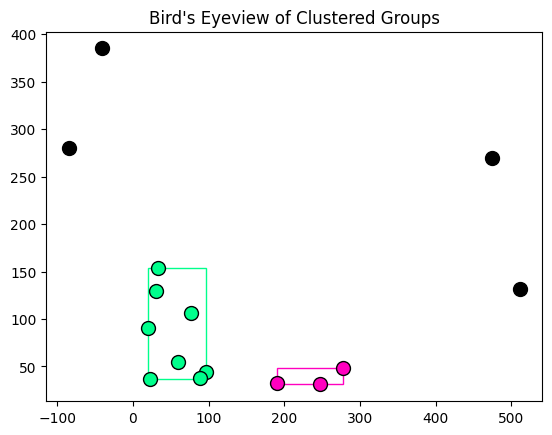

In [22]:
from sklearn.cluster import DBSCAN
import pandas as pd
import matplotlib.patches as patches

# cluster the people in subgroups based on their distance from each other using unsupervised learning (DBSCAN)
# epsilon is set to 200 cm
eps = 200
min_samples = 2
distance_matrix_dbscan = np.array(distance_matrix_dbscan)

# Run DBSCAN
db = DBSCAN(eps=eps, min_samples=min_samples, metric='precomputed')
clusters = db.fit_predict(distance_matrix_dbscan)
labels = db.labels_
unique_labels = np.unique(labels)

# color palette for coloring different subgroups
colors = plt.cm.gist_rainbow(np.linspace(0, 1, len(unique_labels)))
# color dictionary key: labels, value: colors
color_label_dict = {}

bottom_points_transformed = np.array(bottom_points_transformed)

# plot for getting the 2d distribution of points
fig, ax = plt.subplots()

# create the color dictionary for each label and plot each of the points on the graph
for k, col in zip(unique_labels, colors):
    if k == -1:
        col = [0, 0, 0, 1]  # noise points are colored black
    color_label_dict.update({k:col})
    class_member_mask = (labels == k)
    xy = bottom_points_transformed[class_member_mask]
    ax.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col, markeredgecolor='k', markersize=10)

plt.title("Bird's Eyeview of Clustered Groups")

#create a PD dataframe with the bbox coordinates, untransformed bottom points, transformed, distance between points and their labels
df = pd.DataFrame(list(zip(boxes_ref, bottom_points_untransformed, bottom_points_transformed, distance_matrix_dbscan, labels)),
                  columns= ['bboxes_untransformed','untransformed_bottom_points', 'transformed_bottom_points', 'distance_RL_cm', 'labels'])

# get the coordinate of the box around points in each of the subgroup of untransformed points
area_coord_untransformed = df.groupby('labels')['untransformed_bottom_points'].apply(lambda row: (min(p[0] for p in row), min(p[1] for p in row), max(p[0] for p in row), max(p[1] for p in row))).reset_index(name='area_coord_untransformed')

# get the coordinate of the box around points in each fo the subgroup of transformed points
area_coord_transformed = df.groupby('labels')['transformed_bottom_points'].apply(lambda row: (min(p[0] for p in row), min(p[1] for p in row), max(p[0] for p in row), max(p[1] for p in row))).reset_index(name='area_coord_transformed')

#calculate the area of each subgroup's transformed bottom points and change to meters
area_df = df.groupby('labels')['transformed_bottom_points'].apply(lambda row: ((max(p[0] for p in row) - min(p[0] for p in row)) * (max(p[1] for p in row) - min(p[1] for p in row)))).reset_index(name='area_transformed')
area_df['area_transformed'] = area_df['area_transformed'] / 100

#get crowd count
count_df = df.groupby('labels').size().reset_index(name='count')

#merge these calculations together
label_df = pd.merge(area_df, count_df, on='labels')
label_df = pd.merge(label_df, area_coord_untransformed, on='labels')
label_df = pd.merge(label_df, area_coord_transformed, on='labels')

#get the density in people / m^2
label_df['people_per_m2'] = label_df['count'] / label_df['area_transformed']

#get the maximum people density
max_density = max(label_df['people_per_m2'])

# plot the rest of the graph with the squares
for label, col in color_label_dict.items():
    if label != -1:
        coords = area_coord_transformed.loc[area_coord_transformed['labels'] == label, 'area_coord_transformed'].values[0]
        min_x, min_y, max_x, max_y = coords
        rect = patches.Rectangle((min_x, min_y), (max_x - min_x), (max_y - min_y), edgecolor=col, facecolor='none')
        ax.add_patch(rect)

plt.show()

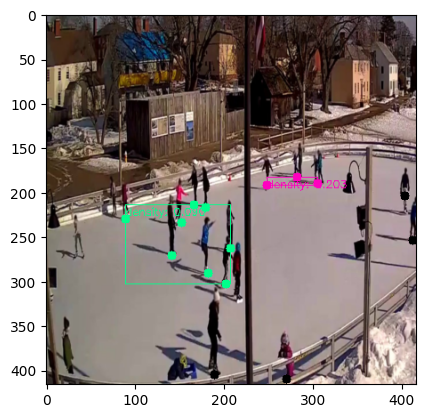

In [27]:
# Function to create visualize the subgroups and their densities on the frame images
import matplotlib.colors as mcolors

# create points on the bottom points of the boundary boxes and color based on label:
def circle_crowd(frame, bboxes_untransformed, color_label_dict):
  for _, person in bboxes_untransformed.iterrows():
    x, y = person['untransformed_bottom_points']
    center = (int(x),int(y))
    color = color_label_dict[person['labels']]
    frame = cv2.circle(frame,center,5,color=color, thickness=-1)
  return frame

#label the crowd density + draw boxes around subclusters of points
def label_crowd_density(frame, label_groups, color_label_dict):
  for label, group in label_groups.groupby('labels'):
    if label != -1:
      crowd_density = group['people_per_m2'].iloc[0]
      min_x, min_y, max_x, max_y = group['area_coord_untransformed'].iloc[0]
      points = np.array([[min_x, min_y], [max_x, min_y], [min_y, max_y], [max_x, max_y]], dtype=np.int32)

      # Reshape the points array to the required shape for cv2.polylines
      points = points.reshape((-1, 1, 2))

      #form boxes around the subclsuters
      cv2.rectangle(frame, [min_x, min_y], [max_x, max_y], color=color_label_dict[label], thickness=None, lineType=None, shift=None)

      #label the crowd densities
      t_size = cv2.getTextSize("AT RISK", 0, fontScale=0.5, thickness=1)[0]
      cv2.putText(frame, f"density: {crowd_density:.3f}", (int(min_x),int(min_y+t_size[1])), 0, 0.4, color_label_dict[label], thickness=1, lineType=cv2.LINE_AA)
      # cv2.rectangle(frame, (int(min_x), int(min_y)), (int(min_x + t_size[0]), int(min_y + t_size[1])), (colors[label]), -1, cv2.LINE_AA)

  return frame

circled_crowd = circle_crowd(image_np.copy(), df, color_label_dict)
labeled_crowd_density = label_crowd_density(circled_crowd, label_df,color_label_dict)
plt.imshow(labeled_crowd_density)
plt.show()

Original social distancing code adapted from: https://medium.com/@joicejoseph/monitor-social-distancing-using-python-yolov5-opencv-78d72c675f5b

In [ ]:
import cv2
import numpy as np
import torch
from matplotlib import pyplot as plt

# Ensure inline plotting for Jupyter notebooks
%matplotlib inline

# Initialize device (assuming a GPU is available, otherwise use CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def draw_predicted_bboxes(image, prediction_list):
  for box_coord in prediction_list:
    x_min, y_min, width, height = box_coord[0], box_coord[1], box_coord[2], box_coord[3]
    cv2.rectangle(image, (int(x_min), int(y_min)), (int(x_min + width), int(y_min+height)), (255, 0, 0), 2)
  return image


# Function to transform points
def transform_points(boxes, matrix):
    bottom_points = []
    for box in boxes:
        pnts = np.array([[[int(box[0] + (box[2] * 0.5)), int(box[1] + box[3])]]], dtype="float32")
        trans_pnts = cv2.perspectiveTransform(pnts, matrix)[0][0]
        pnt = [int(trans_pnts[0]), int(trans_pnts[1])]
        bottom_points.append(pnt)
    return bottom_points

# Function to calculate distance
def calculate_distance(p1, p2, distance_v, distance_h):
    h = abs(p2[1] - p1[1])
    v = abs(p2[0] - p1[0])
    dist_v = float((v / distance_v) * 180)
    dist_h = float((h / distance_h) * 180)
    return int(np.sqrt(((dist_h) ** 2) + ((dist_v) ** 2)))

# Function to perform risk analysis
# bottom point is the changed
def risk_analysis(boxes, bottom_points, distance_v, distance_h):
    distance_matrix = []
    bxs = []
    distance_matrix_wo_risk = []
    for i in range(len(bottom_points)):
        for j in range(len(bottom_points)):
            if i != j:
                dist = calculate_distance(bottom_points[i], bottom_points[j], distance_v, distance_h)
                risk = 1 if dist <= 180 else 0
                distance_matrix.append([bottom_points[i], bottom_points[j], risk])
                bxs.append([boxes[i], boxes[j], risk])
                distance_matrix_wo_risk.append([bottom_points[i], bottom_points[j]])
    return distance_matrix, bxs, distance_matrix_wo_risk

# Function to count safe and at-risk people
def get_count(distance_matrix):
    r = []
    g = []
    for i in range(len(distance_matrix)):
        if distance_matrix[i][2] == 1:
            if distance_matrix[i][0] not in r and distance_matrix[i][0] not in g:
                r.append(distance_matrix[i][0])

            if distance_matrix[i][1] not in r and distance_matrix[i][1] not in g:
                r.append(distance_matrix[i][1])

    for i in range(len(distance_matrix)):
            if distance_matrix[i][0] not in r and distance_matrix[i][0] not in g:
                g.append(distance_matrix[i][0])
            if distance_matrix[i][1] not in r and distance_matrix[i][1] not in g:
                g.append(distance_matrix[i][1])

    return len(r), len(g)

# Function to create bird's-eye view
def bird_eye_view(frame, distance_matrix, bottom_points,scale_w, scale_h):

    h,w = frame.shape[0],frame.shape[1]
    red = (255, 0, 0); green = (0, 255, 0) ; white = (200, 200, 200)
    blank_image = np.zeros((int(h * scale_h), int(w * scale_w), 3), np.uint8)
    blank_image[:] = white
    r,g = [],[]

    for i in range(len(distance_matrix)):
        if distance_matrix[i][2] == 1:
            if (distance_matrix[i][0] not in r) and (distance_matrix[i][0] not in g):
                r.append(distance_matrix[i][0])
            if (distance_matrix[i][1] not in r) and (distance_matrix[i][1] not in g):
                r.append(distance_matrix[i][1])
            blank_image = cv2.line(blank_image, (int(distance_matrix[i][0][0]),
                                   int(distance_matrix[i][0][1] )),
                                   (int(distance_matrix[i][1][0]),
                                   int(distance_matrix[i][1][1])), red, 2)

    for i in range(len(distance_matrix)):
        if distance_matrix[i][2] == 0:
            if (distance_matrix[i][0] not in r) and (distance_matrix[i][0] not in g):
                g.append(distance_matrix[i][0])
            if (distance_matrix[i][1] not in r) and (distance_matrix[i][1] not in g):
                g.append(distance_matrix[i][1])

    for i in bottom_points:
        blank_image = cv2.circle(blank_image, (int(i[0]), int(i[1])), 5, green, 10)
    for i in r:
        blank_image = cv2.circle(blank_image, (int(i[0]), int(i[1])), 5, red, 10)

    blank_image = cv2.resize(blank_image, (w, h))

    return blank_image
# Function to display social distancing analysis on the frame

def social_distancing(frame, distance_matrix, boxes, risk_count):
    for i in range(len(boxes)):
        x,y,w,h = boxes[i][:]
        center = (int(x+w*0.5),int(y+h*0.5))
        frame = cv2.circle(frame,center,5,(0,255,0),2)
    red = (255,0,0)
    for i in range(len(distance_matrix)):
        per1, per2, risk = distance_matrix[i][0], distance_matrix[i][1], distance_matrix[i][2]

        if risk == 1:
            x,y,w,h = per1[:]
            center = (int(x+w*0.5),int(y+h*0.5))
            t_size = cv2.getTextSize("AT RISK", 0, fontScale=0.5, thickness=1)[0]
            cv2.rectangle(frame, (int(x), int(y)), (int(x + t_size[0]), int(y + t_size[1])), red, -1, cv2.LINE_AA)

            cv2.putText(frame, "AT RISK", (int(x),int(y+t_size[1])), 0, 0.5, [0, 0, 0], thickness=1, lineType=cv2.LINE_AA)
            cv2.circle(frame,center,5,red,2)
            x1,y1,w1,h1 = per2[:]
            center = (int(x1+w1*0.5),int(y1+h1*0.5))
            t_size = cv2.getTextSize("AT RISK", 0, fontScale=0.5, thickness=1)[0]
            cv2.rectangle(frame,(int(x),int(y)),(int(x+t_size[0]),int(y+t_size[1])),red,-1, \
                          cv2.LINE_AA)
            cv2.putText(frame, "AT RISK", (int(x),int(y+t_size[1])), 0, 0.5, [0, 0, 0], thickness=1, \
                        lineType=cv2.LINE_AA)
            frame = cv2.circle(frame,center,5,red,2)
            frame = cv2.line(frame, (int(x+w/2), int(y+h/2)), (int(x1+w1/2), int(y1+h1/2)), \
                             red, 2)

    pad = np.full((140,frame.shape[1],3), [0, 0, 0], dtype=np.uint8)
    cv2.putText(pad, "-- AT RISK : " + str(risk_count[0]) + " people", (50, 60), \
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 1)
    cv2.putText(pad, "-- SAFE : " + str(risk_count[1]) + " people", (50,  100), \
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 1)
    frame = np.vstack((frame,pad))
    return frame

# Function to concatenate images vertically with resizing
def vconcat_resize(img_list, interpolation=cv2.INTER_CUBIC):
    w_min = min(img.shape[1] for img in img_list)
    im_list_resize = [cv2.resize(img, (w_min, int(img.shape[0] * w_min / img.shape[1])), interpolation=interpolation) for img in img_list]
    return cv2.vconcat(im_list_resize)

boxes1 = prediction[0].boxes.xyxy.tolist()
boxes_ref = [[box[0], box[1], box[2] - box[0], box[3] - box[1]] for box in boxes1]

annotated_image = draw_predicted_bboxes(image_np.copy(), boxes_ref)
annotated_image_rgb = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)

# Display the annotated image using Matplotlib
plt.imshow(annotated_image_rgb)
plt.axis('off')
plt.show()

# Convert the bounding box coordinates to NumPy array for easier manipulation
points = [[350, 150],[416,300], [300, 400], [0,200], [300,155], [350,150], [275,145]]
corner_points_arr = np.float32(points[:4])

H, W = image_np.shape[:2]
img_params = np.float32([[W, 0], [W, H], [0, H], [0, 0]])
matrix = cv2.getPerspectiveTransform(corner_points_arr, img_params)

person_points = transform_points(boxes_ref, matrix)

pts = np.float32(np.array([points[4:7]]))
warped_pt = cv2.perspectiveTransform(pts, matrix)[0]

distance_v = np.sqrt((warped_pt[0][0] - warped_pt[1][0]) ** 2 + (warped_pt[0][1] - warped_pt[1][1]) ** 2)
distance_h = np.sqrt((warped_pt[0][0] - warped_pt[2][0]) ** 2 + (warped_pt[0][1] - warped_pt[2][1]) ** 2)

distance_matrix, bxs_mat, distance_matrix_wo_risk = risk_analysis(boxes_ref, person_points, distance_v, distance_h)
risk_count = get_count(distance_matrix)

bird_image = bird_eye_view(image_np, distance_matrix, person_points, 2, 2)

plt.imshow(bird_image)
plt.axis('off')
plt.show()


# Perform social distancing analysis and add text annotations
final_image = social_distancing(image_np.copy(), bxs_mat, boxes_ref, risk_count)


# Display the final image
plt.imshow(np.vstack((annotated_image_rgb, bird_image, final_image)))
plt.show()
